In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
import os

from astropy.io import fits, ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
# import TheCannon
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [121]:
man_keys = ['Name','RAdeg', 'DEdeg', 'Fbol', 'e_Fbol', 'Teff', \
       'e_Teff', 'R', 'e_R', 'M', 'e_M', '[Fe/H]', 'e_[Fe/H]', 'SpType', \
       'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'Rcmag', 'e_Rcmag', 'Icmag', \
       'e_Icmag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', \
       'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Ksmag', \
       'e_Ksmag', 'Gaiamag', 'e_Gaiamag', 'BPmag', 'e_BPmag', 'RPmag', \
       'e_RPmag', 'ModFbol', 'e_ModFbol', 'ModTeff', 'e_ModTeff', 'ModR', \
       'e_ModR', 'ModM', 'e_ModM', 'ModAge', 'e_ModAge']
asp_keys = ['APOGEE_ID', 'RA', 'DEC', 'SNR', 'FPARAM', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'VSINI', 'VHELIO_AVG']
gil_keys = ['RAdeg', 'DEdeg', 'vsini', 'e_vsini']
wes_keys = ['_RAJ2000', '_DEJ2000',  'SpT', 'Dist', 'W_Ha_']

In [122]:
man_raw = ascii.read('https://arxiv.org/src/1501.01635v3/anc/Tables5_6_7.txt')
bon_raw = ascii.read('raw/bonus_raw.txt')
asp_raw = fits.open(AP_PATH + '/allStar-l31c.2.fits')
gil_raw = ascii.read('http://iopscience.iop.org/1538-3881/155/1/38/suppdata/ajaa9c7ct4_mrt.txt')
wes_raw = fits.open('raw/west_raw.fits')

In [127]:
blank_list = [np.nan for i in range(len(bon_raw))]
miss_key = list(set(man_raw.keys()) - set(bon_raw.keys()))
miss_dict = {key:blank_list for key in miss_key}

bon_dict = {**{key:bon_raw[key] for key in list(bon_raw.keys())}, **miss_dict}
mnr_dict = {key:man_raw[key] for key in man_keys}

man_dict = {key:[*mnr_dict[key], *bon_dict[key]] for key in man_keys}
asp_dict = {key:asp_raw[1].data[key] for key in asp_keys}
wes_dict = {key:wes_raw[1].data[key] for key in wes_keys}
gil_dict = {key:gil_raw[key] for key in gil_keys}

man_table = Table(list(man_dict.values()), names=tuple(man_dict.keys()))
asp_table = Table(list(asp_dict.values()), names=tuple(asp_dict.keys()))
wes_table = Table(list(wes_dict.values()), names=tuple(wes_dict.keys()))
gil_table = Table(list(gil_dict.values()), names=tuple(gil_dict.keys()))

man_table.write('select_par/mann_select_par.fits', format='fits')
asp_table.write('select_par/aspcap_select_par.fits', format='fits')
wes_table.write('select_par/west_select_par.fits', format='fits')
gil_table.write('select_par/gil_select_par.fits', format='fits')

/home/jess/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:230: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)


Read in x-matched lists:

In [206]:
xmatch = pd.read_csv('match/apogee_x_mann.csv')
fparam = np.array([x.split('(')[1].split(',') for x in xmatch['FPARAM']])
fteff = [float(x) for x in fparam.T[0]]
ffe_h = [float(x) for x in  fparam.T[2]]

In [208]:
# for name in xmatch['APOGEE_ID']:
#     ap.download(name, dir=AP_PATH+'/training_sets/mann_bonus2/')
dl_ids = [x.split('2-')[1].split('.fits')[0] for x in os.listdir(AP_PATH+'/training_sets/mann_bonus2/')]
set(xmatch['APOGEE_ID']) - set(dl_ids), set(dl_ids) - set(xmatch['APOGEE_ID'])

(set(), set())

2
38


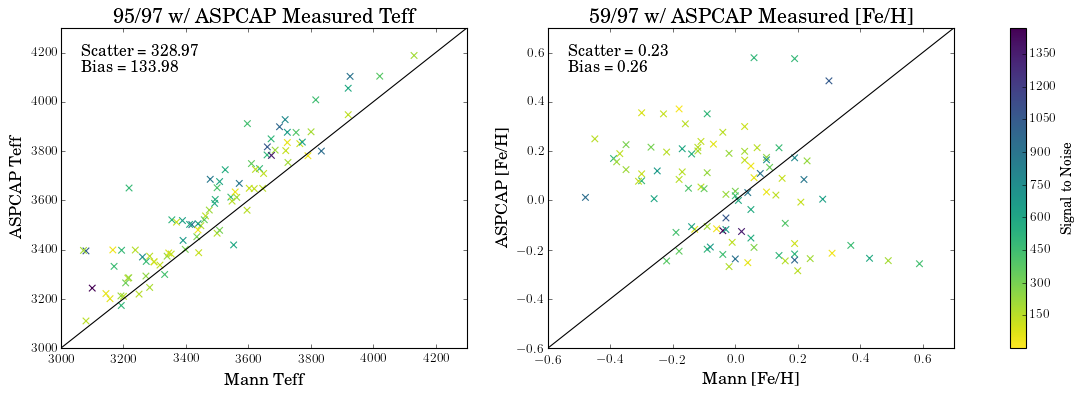

97 sources


In [196]:
plot2Par(xmatch['Teff'], fteff, xmatch['[Fe/H]'], ffe_h, cfac=xmatch['SNR'])
print(len(xmatch), 'sources')

In [195]:
def plot2Par(t1, t2, f1, f2, **kwargs):
    
    cfac = kwargs.get('cfac')
    if 'cfac' in kwargs:
        color = True
    
    t1, t2, f1, f2 = np.array(t1), np.array(t2), np.array(f1), np.array(f2)
    line = np.arange(-10,5000,100)

    scat1 = round(np.std(t1[t2 > 0] - t2[t2 > 0]), 2)
    bias1 = -1*round(np.mean(t1[t2 > 0] - t2[t2 > 0]), 2)
    text1 = 'Scatter = %s \nBias = %s'%(scat1, bias1)

    scat2 = round(np.std(f1[f2 > 0] - f2[f2 > 0]), 2)
    bias2 = -1*round(np.mean(f1[f2 > 0] - f2[f2 > 0]), 2)
    text2 = 'Scatter = %s \nBias = %s'%(scat2, bias2)

    print(len(t1[t2 < 0]))
    print(len(f1[f2 < 0]))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])

    if color == True:
        pl = ax1.scatter(t1, t2, marker='x', s=35, c=cfac, cmap='viridis_r')
    else:
        ax1.scatter(t1, t2, marker='x', s=35)
    ax1.plot(line, line, color='k', linewidth=1)
    ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
    ax1.set_ylim([3000,4300])
    ax1.set_xlim([3000,4300])
    ax1.set_xlabel('Mann Teff', fontsize=15)
    ax1.set_ylabel('ASPCAP Teff', fontsize=15)
    ax1.set_title('{}/{} w/ ASPCAP Measured Teff'.format(len(t2[t2 > 0]), len(t2)), fontsize=18)

    if color == True:
        ax2.scatter(f1, f2, marker='x', s=35, c=cfac, cmap='viridis_r')
    else:
        ax2.scatter(f1, f2, marker='x', s=35)
    ax2.plot(line, line, color='k', linewidth=1)
    ax2.text(0.05, 0.95, text2, fontsize=14, transform=ax2.transAxes, verticalalignment='top')
    ax2.set_ylim([-.6,.7])
    ax2.set_xlim([-.6,.7])
    ax2.set_xlabel('Mann [Fe/H]', fontsize=15)
    ax2.set_ylabel('ASPCAP [Fe/H]', fontsize=15)
    ax2.set_title('{}/{} w/ ASPCAP Measured [Fe/H]'.format(len(f2[f2 > 0]), len(f2)), fontsize=18)
    
    if color == True:
        cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
        cb.set_label('Signal to Noise', fontsize=12)
    plt.show()